In [1]:
!nvidia-smi

Mon May 26 00:08:28 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.28                 Driver Version: 576.28         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1660      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             15W /  130W |     678MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#general libraries
import cv2
import numpy as np
import torch 
import torchvision.transforms.functional
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.metrics import r2_score

In [3]:
#special libraries for LoFTR

!pip install kornia
!pip install kornia_moons
!pip install tqdm

from tqdm import tqdm
import random

import kornia as K
import kornia.feature as KF
from kornia_moons.viz import draw_LAF_matches


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
#select device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
#ADM_UAV_Flight1_dataset

#select MAP
MAP_GSD = 1160 / 4800
MAPS_NAMES = ["AdM-01-2014", "AdM-03-2014", "AdM-06-2015", "AdM-08-2013", "AdM-10-2010"]
MAP_NAME = MAPS_NAMES[0]

#dataset params
PATH = 'Flight 1/'
FIRST_IDX = 48 
LAST_IDX = 405
FRAMES_NUM = LAST_IDX - FIRST_IDX + 1
print(f"FRAMES_NUM = {FRAMES_NUM}")

#load the true data of fly
ground_truth = np.loadtxt(PATH + "traj1_ground_truth.txt", skiprows=1)
TRUE_PS, TRUE_SS, TRUE_AS = ground_truth[:, 0:2], ground_truth[:, 2], ground_truth[:, 3]
del ground_truth

#function to get true position, angle, scale
def get_ground_truth_adm(idx):
    #print(f'Ground truth: {TRUE_PS[idx], TRUE_AS[idx], TRUE_SS[idx]}')
    return TRUE_PS[idx], TRUE_AS[idx], TRUE_SS[idx] 

FRAMES_NUM = 358


In [6]:
#own image loading function
def get_tframe_LoFTR(idx):
    img = cv2.imread(PATH + f"image{(idx + FIRST_IDX):06d}.png", cv2.IMREAD_COLOR)
    #print(f'dtype: {img.dtype}, shape: {img.shape}, min: {np.min(img)}, max: {np.max(img)}')
    img_raw = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # (H, W)
    #img_raw = cv2.resize(img_raw, (img_raw.shape[1]//8*8, img_raw.shape[0]//8*8))  # input size shuold be divisible by 8
    frame = torch.from_numpy(img_raw)[None][None].to(device) / 255.

    return frame

#library image loading function
def get_tframe_LoFTR2(idx):
    img1 = K.io.load_image(PATH + f"image{(idx + FIRST_IDX):06d}.png", K.io.ImageLoadType.RGB32)[None, ...].to(device)
    #print(img1.shape)
    img1 = K.geometry.resize(img1, (600, 375), antialias=True)
    img1 = K.color.rgb_to_grayscale(img1)

    return img1

#MAP loading function
def get_tmap_adm_LoFTR(map_name):
    MAP=cv2.imread(f'Maps/{map_name}.png', cv2.IMREAD_COLOR)
    #print(f'dtype: {MAP.dtype}, shape: {MAP.shape}, min: {np.min(MAP)}, max: {np.max(MAP)}')
    MAP = cv2.cvtColor(MAP, cv2.COLOR_BGR2GRAY)  # (H, W)
    #MAP = cv2.resize(MAP, (MAP.shape[1]//8*8, MAP.shape[0]//8*8))  # input size shuold be divisible by 8
    TMAP=torch.from_numpy(MAP)[None][None].to(device) / 255.
    #print("map:", TMAP.shape, TMAP.type(), TMAP.max().cpu().item(), TMAP.min().cpu().item())
    return TMAP
    
#function to visualize matchings
def viz_LoFTR(tframe, chunk, inliers, mkpts0, mkpts1):
    draw_LAF_matches(
        KF.laf_from_center_scale_ori(
            torch.from_numpy(mkpts0).view(1, -1, 2),
            torch.ones(mkpts0.shape[0]).view(1, -1, 1, 1),
            torch.ones(mkpts0.shape[0]).view(1, -1, 1),
        ),
        KF.laf_from_center_scale_ori(
            torch.from_numpy(mkpts1).view(1, -1, 2),
            torch.ones(mkpts1.shape[0]).view(1, -1, 1, 1),
            torch.ones(mkpts1.shape[0]).view(1, -1, 1),
        ),
        torch.arange(mkpts0.shape[0]).view(-1, 1).repeat(1, 2),
        K.tensor_to_image(tframe),
        K.tensor_to_image(chunk),
        inliers,
        draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": None, "feature_color": (0.2, 0.5, 1), "vertical": False},
    )

In [7]:
#load TMAP in system
TMAP = get_tmap_adm_LoFTR(MAP_NAME)
print("map:", TMAP.shape, TMAP.type(), TMAP.max().cpu().item(), TMAP.min().cpu().item())

map: torch.Size([1, 1, 4800, 4800]) torch.cuda.FloatTensor 1.0 0.0


In [8]:
#load matcher to system
matcher = KF.LoFTR(pretrained="outdoor").eval().to(device)
print(matcher)

LoFTR(
  (backbone): ResNetFPN_8_2(
    (conv1): Conv2d(1, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1

In [9]:
#function to matching image and map
def map_match_LoFTR(tmap, tframe, pos, angle, scale, Kk):

    posX, posY = int(pos[0]), int(pos[1]) #get posiition

    #transform the image from UAV
    tframe = torchvision.transforms.functional.resize(tframe, (round(tframe.shape[2] * scale), round(tframe.shape[3] * scale)))
    tframe = torchvision.transforms.functional.rotate(tframe, -90-angle)

    #Create and tranform mask
    mask = torch.ones_like(tframe, dtype=torch.bool, device=device)
    mask = torchvision.transforms.functional.resize(mask, (round(tframe.shape[2] * scale), round(tframe.shape[3] * scale)))
    mask = torchvision.transforms.functional.rotate(mask, -90-angle)

    #determining the size and boundaries of a map area
    rW = int(tframe.shape[3] * Kk / 2)
    rH = int(tframe.shape[2] * Kk / 2)

    px0 = max(posX - rW, 0)
    px1 = min(posX + rW, tmap.shape[3])
    py0 = max(posY - rH, 0)
    py1 = min(posY + rH, tmap.shape[2])

    #masking
    chunk = tmap[..., py0:py1, px0:px1]
    mask = torchvision.transforms.functional.resize(mask, (py1-py0, px1-px0))
    chunk = chunk * mask
    
    #image matching
    batch = {'image0' : chunk, 'image1': tframe}
    
    with torch.inference_mode():  
        try:
            correspondences = matcher(batch)
            mkpts0 = correspondences["keypoints0"].cpu().numpy()
            mkpts1 = correspondences["keypoints1"].cpu().numpy()
        except RuntimeError as e:            
            return (0, 0), 0, pos, 0, 0, 0, 0 
    
    #keypoint filtering
    affine_mat, inliers = cv2.estimateAffine2D(mkpts0, mkpts1, method=cv2.RANSAC,  ransacReprojThreshold=10, confidence=0.95)
    #Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 3.0, 0.95, 100000)
    #H, inliers = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 10.0)
    N0=np.sum(inliers)
    if (N0<6):
        return (0, 0), 0, pos, 0, 0, 0, 0
    
    frame_center = np.array([[tframe.shape[3] / 2, tframe.shape[2] / 2]] * N0)
    m_kpts0 = []
    m_kpts1 = []
    for i in range(len(inliers)):
        if inliers[i]>0:
            m_kpts0.append(mkpts0[i])
            m_kpts1.append(mkpts1[i])
    
    m_kpts0 = np.array(m_kpts0)
    m_kpts1 = np.array(m_kpts1)

    #linear regression for prediction
    X, Y = (m_kpts1 - frame_center), m_kpts0

    model = None
    model = RANSACRegressor(estimator=LinearRegression(), min_samples=5)
    model.fit(X, Y)
    v = model.predict(np.array([[0, 0]]))
    v = (v[0, 0], v[0, 1])
    #predict position
    dp = np.array([0, 0]) - (rW, rH) + v
    dp = np.clip(pos + dp, 0, tmap.shape[3])-pos
    #predict angle
    da = np.degrees(-np.arctan2(affine_mat[1, 0], affine_mat[0, 0]))
    angle_pred = angle+da

    #predict scale
    k = np.abs(np.linalg.det(model.estimator_.coef_[0:2, 0:2]))
    k = k / np.abs(k) * np.sqrt(np.abs(np.linalg.det(model.estimator_.coef_)))
    ds = scale * (np.abs(k) - 1)/Kk

    #viz_LoFTR(chunk, tframe, inliers, mkpts0, mkpts1)
    del model

    return np.linalg.norm(dp), dp , pos+dp, da, ds, inliers, N0

In [10]:
#test function to map matching
import time
def LoFTR_map_match_test(idx):
    pos, angle, scale = get_ground_truth_adm(idx-1)
    pos0, angle0, scale0 = get_ground_truth_adm(idx)
    print(f'IDX = {idx}')
    start = time.time()
    aed, dp, pos_pred, da, ds, inliers, outliers = map_match_LoFTR(TMAP, get_tframe_LoFTR(idx), pos, angle, scale, 1.5)
    spend_time = time.time() - start
    print(f'pos_before: {pos}; pos truth: {pos0}; predict: {pos_pred}; dp: {dp}')
    print(f'angle_before: {angle}; angle truth: {angle0}; predict: {angle+da}; da = {da}, angle_error = {angle0 - (angle+da)}')
    print(f'scale_before: {scale}; scale truth: {scale0}; predict: {scale+ds}, ds = {ds}, scale_error = {scale0 - (scale+ds)} ')
    print(f'outliers = {outliers}, time = {spend_time}')
    print(f'ERRORS : \n\taed_pos (pix) = {np.linalg.norm(pos_pred - pos0):.0f}, aed_pos (m) = {np.linalg.norm(pos_pred - pos0)*MAP_GSD}\n\tangle_error = {angle0 - (angle+da)}\n\tscale_error = {scale0 - (scale+ds)}')
    print('________________________________')

for i in range(220, 245):
    LoFTR_map_match_test(i)

IDX = 220
pos_before: [3053. 2156.]; pos truth: [3069. 2144.]; predict: [3061.94454513 2102.79803525]; dp: [  8.94454513 -53.20196475]
angle_before: -43.9783734; angle truth: -42.94649; predict: -34.11905715116242; da = 9.85931624883758, angle_error = -8.827432848837574
scale_before: 0.5948767969; scale truth: 0.5946711719; predict: 0.6426506452590455, ds = 0.047773848359045495, scale_error = -0.04797947335904551 
outliers = 238, time = 3.8311538696289062
ERRORS : 
	aed_pos (pix) = 42, aed_pos (m) = 10.10207524407814
	angle_error = -8.827432848837574
	scale_error = -0.04797947335904551
________________________________
IDX = 221
pos_before: [3069. 2144.]; pos truth: [3089. 2130.]; predict: [3081.3135906  2093.89757925]; dp: [ 12.3135906  -50.10242075]
angle_before: -42.94649; angle truth: -41.35366; predict: -29.66972234896228; da = 13.276767651037717, angle_error = -11.683937651037716
scale_before: 0.5946711719; scale truth: 0.5945316406; predict: 0.6373115731343908, ds = 0.04264040123

In [43]:
def complex2array(z):
    return np.array([np.real(z), np.imag(z)])

#pair match function
def pair_match_predict_LoFTR(img0, img1, pos0, angle0, scale0):
    #image matching
    batch = {'image0' : img0, 'image1': img1}
    
    with torch.inference_mode():
        correspondences = matcher(batch)
        mkpts0 = correspondences["keypoints0"].cpu().numpy()
        mkpts1 = correspondences["keypoints1"].cpu().numpy()

    #keypoint filtering
    affine_mat, inliers = cv2.estimateAffine2D(mkpts0, mkpts1, method=cv2.RANSAC, ransacReprojThreshold=1, confidence=0.999)
    #Fm, inliers = cv2.findFundamentalMat(mkpts0, mkpts1, cv2.USAC_MAGSAC, 0.5, 0.999, 100000)
    #Hom, inliers = cv2.findHomography(mkpts0, mkpts1, cv2.RANSAC, 10.0)

    H, W = img0.shape[2], img0.shape[3]

    N0=np.sum(inliers)
    
    frame_center = np.array([[W / 2, H / 2]]*N0)
    
    m_kpts0 = []
    m_kpts1 = []
    for i in range(len(inliers)):
        if inliers[i]>0:
            m_kpts0.append(mkpts0[i])
            m_kpts1.append(mkpts1[i])
    
    m_kpts0 = np.array(m_kpts0)
    m_kpts1 = np.array(m_kpts1)
    
    #linear regression for prediction

    X, Y = m_kpts0 - frame_center, m_kpts1 - frame_center
    
    model = None
    model = RANSACRegressor(estimator=LinearRegression(), min_samples=5)
    model.fit(X, Y)

    k = np.abs(np.linalg.det(model.estimator_.coef_[0:2, 0:2]))
    k = k / np.abs(k) * np.sqrt(np.abs(np.linalg.det(model.estimator_.coef_)))

    #predict position
    pos1_pred = model.predict(np.array([[0, 0]]))
    pos1_pred = pos1_pred[0, 0] + 1j * pos1_pred[0, 1]
    dp = complex2array(scale0 * np.exp(1j * (-90 + angle0) / 180 * np.pi) * pos1_pred) 
    #predict scale
    ds = scale0 * (np.abs(k) - 1)

    pos = pos0 + dp
    #predict angle
    angle_rad = np.arctan2(affine_mat[1, 0], affine_mat[0, 0])
    da = np.degrees(-angle_rad)
    #viz_LoFTR(img0, img1, inliers, mkpts0, mkpts1)
    

    del img0, img1, model
    return dp, dp+pos0, da, ds, len(inliers), N0



In [44]:
#test function for pair matching
def LoFTR_pair_match_test(idx1, idx2):
    pos0, angle0, scale0 = get_ground_truth_adm(idx1)
    pos, angle, scale = get_ground_truth_adm(idx2)
    start = time.time()
    dp, pos_pred, da, ds, _, N0 = pair_match_predict_LoFTR(get_tframe_LoFTR(idx1), get_tframe_LoFTR(idx2), pos0, angle0, scale0)
    spend_time = time.time() - start
    print(f'mathes idxes: {idx1, idx2}')
    print(f'pos before: {pos0}; pos truth: {pos}; predict: {pos0+dp}')
    print(f'angle before: {angle0}; angle truth: {angle}; predict: {angle0 + da}')
    print(f'scale before: {scale0}; scale truth: {scale}; predict: {scale0+ds}')
    print(f'outliers = {N0}, time = {spend_time}')
    print(f'ERRORS : \n\taed_pos (pix) = {np.linalg.norm(pos_pred - pos):.0f}, aed_pos (m) = {np.linalg.norm(pos_pred - pos)*MAP_GSD}\n\tangle_error = {angle - (angle0+da)}\n\tscale_error = {scale - (scale0+ds)}')
    print('________________________________')

for i in range(220, 245):
    torch.cuda.empty_cache()
    LoFTR_pair_match_test(i-1, i)


mathes idxes: (219, 220)
pos before: [3053. 2156.]; pos truth: [3069. 2144.]; predict: [3066.0849554  2142.31188115]
angle before: -43.9783734; angle truth: -42.94649; predict: -42.10364161907781
scale before: 0.5948767969; scale truth: 0.5946711719; predict: 0.5951012505095838
outliers = 7465, time = 1.9273242950439453
ERRORS : 
	aed_pos (pix) = 3, aed_pos (m) = 0.8140698794634368
	angle_error = -0.8428483809221845
	scale_error = -0.0004300786095838838
________________________________
mathes idxes: (220, 221)
pos before: [3069. 2144.]; pos truth: [3089. 2130.]; predict: [3084.39346742 2127.97391394]
angle before: -42.94649; angle truth: -41.35366; predict: -41.09965411637041
scale before: 0.5946711719; scale truth: 0.5945316406; predict: 0.5951021178659563
outliers = 6349, time = 1.527771234512329
ERRORS : 
	aed_pos (pix) = 5, aed_pos (m) = 1.2161661528691095
	angle_error = -0.2540058836295884
	scale_error = -0.0005704772659563817
________________________________
mathes idxes: (221, 2

In [20]:
#test map matching at different scale factors with known coordinates
Ks = [1.0, 1.5, 2.0, 2.5, 3.0]

averages_m = []
averages_pix = []

for Kk in Ks:
    plt.figure(figsize=(15,15))
    predict_pos_s = []
    aed_s = []
    inliers = []
    outliers = []

    for idx in tqdm(range(FRAMES_NUM)):
        
        pos, angle, scale = get_ground_truth_adm(idx)
        aed, dp, predict_pos, da, ds, inlier, otlier = map_match_LoFTR(TMAP, get_tframe_LoFTR(idx), pos, angle, scale, Kk) #returns np.linalg.norm(dp), dp , pos+dp, da, ds, inliers, N0

        aed_s.append(aed)
        predict_pos_s.append(predict_pos)
        inliers.append(inlier)
        outliers.append(outliers)

    print(f'Zoom K: {Kk}')

    
    print(f'average position: {sum(aed_s)/len(aed_s)} pix')
    averages_pix.append(sum(aed_s)/len(aed_s))
    
    print(f'average position: {sum(aed_s)/len(aed_s)*MAP_GSD} m')
    averages_m.append(sum(aed_s)/len(aed_s)*MAP_GSD)

    position = np.array(TRUE_PS)
    predict_position = np.array(predict_pos_s)
    # Первый график (позиция)
    plt.subplot(3, 1, 1)
    plt.imshow(K.tensor_to_image(TMAP))
    plt.plot(predict_position[:, 0], predict_position[:, 1], 'r--', label='Predicted Position')
    plt.plot(position[:, 0], position[:, 1], 'g-', label='True Position')
    plt.ylabel("Position, m")
    plt.legend()  
    plt.grid()

    # Второй график (позиция)
    plt.subplot(3, 1, 2)
    plt.plot(predict_position, 'r--', label='Predicted Position')
    plt.plot(position, 'g-', label='True Position')
    plt.ylabel("Position, m")
    plt.legend()  
    plt.grid()

    # Второй график (AED)
    plt.subplot(3, 1, 3)
    plt.plot(np.array(aed_s)*MAP_GSD)
    plt.ylabel("AED, m")
    plt.grid()

 27%|██▋       | 96/358 [00:18<00:49,  5.25it/s]


KeyboardInterrupt: 

<Figure size 1500x1500 with 0 Axes>

averages_pix = [np.float64(35.33458300673336), np.float64(47.37735690125385), np.float64(77.80212376844423), np.float64(128.9207850308699), np.float64(155.60802170189376)]
averages_m = [np.float64(8.539190893293895), np.float64(11.449527917803014), np.float64(18.802179910707356), np.float64(31.155856382460225), np.float64(37.60527191129099)]


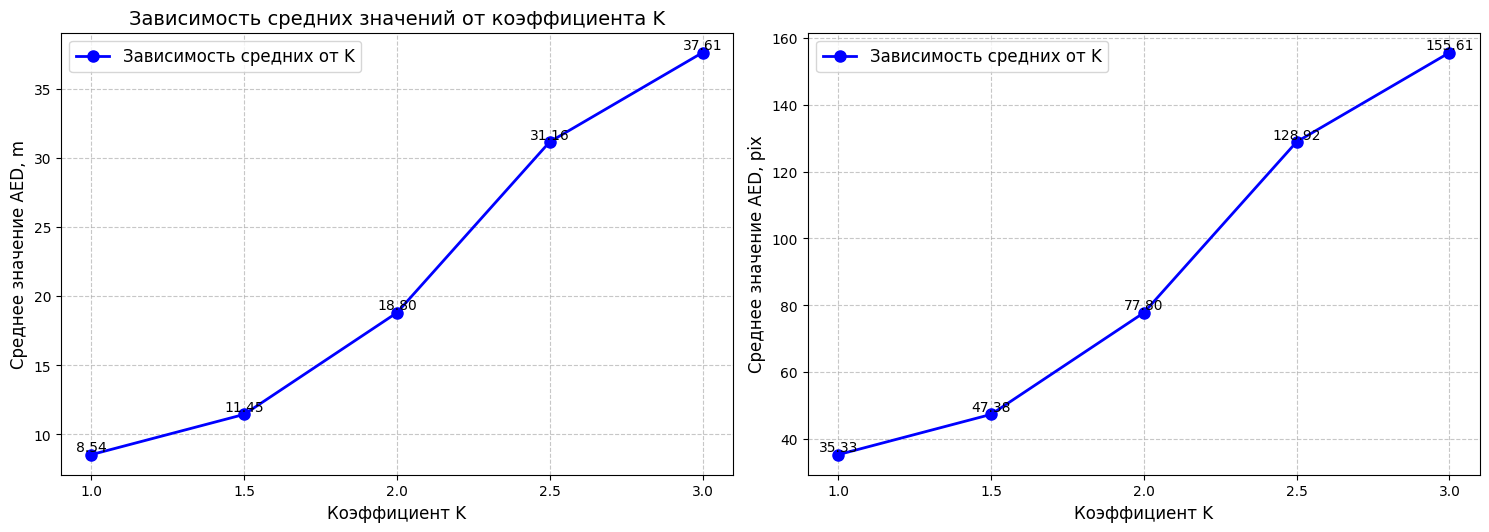

In [ ]:
#visualize results
print(f'averages_pix = {averages_pix}\naverages_m = {averages_m}')
plt.figure(figsize=(15, 10))

# Основной график (линия + точки)
plt.subplot(2, 2, 1)
plt.plot(Ks, averages_m, 'bo-', linewidth=2, markersize=8, label='Зависимость средних от K')

# Дополнительные элементы
plt.title('Зависимость средних значений от коэффициента K', fontsize=14)
plt.xlabel('Коэффициент K', fontsize=12)
plt.ylabel('Среднее значение AED, m', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Подписи точек
for k, avg in zip(Ks, averages_m):
    plt.text(k, avg, f'{avg:.2f}', ha='center', va='bottom', fontsize=10)

# Легенда и оформление
plt.legend(fontsize=12)
plt.xticks(Ks)  # Обеспечиваем метки для всех значений K
plt.tight_layout()


plt.subplot(2, 2, 2)
plt.plot(Ks, averages_pix, 'bo-', linewidth=2, markersize=8, label='Зависимость средних от K')

# Дополнительные элементы
plt.xlabel('Коэффициент K', fontsize=12)
plt.ylabel('Среднее значение AED, pix', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Подписи точек
for k, avg in zip(Ks, averages_pix):
    plt.text(k, avg, f'{avg:.2f}', ha='center', va='bottom', fontsize=10)

# Легенда и оформление
plt.legend(fontsize=12)
plt.xticks(Ks)  # Обеспечиваем метки для всех значений K
plt.tight_layout()


plt.show()

In [ ]:
#flight simulating function
def fly(pos0, angle0, scale0, idx_start):
    position = []
    pos_MM = []
    pos_PM = []
    pos_err = []
    angle_err = []
    scale_err = []

    Kk = 1.5
    

    #getting initial coordinates
    pos_now = pos0
    angle_now = angle0
    scale_now = scale0

    position.append(pos_now)
    pos_MM.append(pos_now)
    pos_PM.append(pos_now)
    #start fly
    img_past = get_tframe_LoFTR(idx_start)
    for idx in tqdm(range(100, 200)):
        
        img = get_tframe_LoFTR(idx)

        true_pos, true_angle, true_scale = get_ground_truth_adm(idx)

        #map matching
        aed_MM, dp_MM, pos_pred_MM, da_MM, ds_MM, inliers_MM, outliers_MM = map_match_LoFTR(get_tmap_adm_LoFTR(MAP_NAME), img, pos_now, angle_now, scale_now, Kk)
        torch.cuda.empty_cache()
        
        #pair matching with past image
        dp_PM, pos_pred_PM, da_PM, ds_PM, inliers_PM, outliers_PM = pair_match_predict_LoFTR(img_past, img, pos_now, angle_now, scale_now)
        torch.cuda.empty_cache()

        pos_MM.append(pos_pred_MM)
        pos_PM.append(pos_pred_PM)

        #combination of methods results
        if (aed_MM == 0):
            pos_now = pos_pred_PM
            angle_now = (angle_now + da_PM + 180) %360 - 180
            scale_now = scale_now +ds_PM
        else:
            pos_now = (pos_pred_MM + pos_pred_PM)/2
            angle_now = (angle_now + (da_MM + da_PM)/2 + 180) %360 - 180
            scale_now = scale_now + (ds_MM + ds_PM)/2
        
        position.append(pos_now)

        img_past = img.detach().clone()  # Явное копирование без градиентов
        del img
        torch.cuda.empty_cache()
        #print(f'TRUE POS: {true_pos}; predict POS: {pos_now}; POS error: {np.linalg.norm(true_pos - pos_now)}')
        pos_err.append(np.linalg.norm(true_pos - pos_now))
        angle_err.append(true_angle - angle_now)
        scale_err.append(true_scale - scale_now)

    return position, pos_err, angle_err, scale_err, pos_MM, pos_PM

In [ ]:
#start fly imitation
pos0, angle0, scale0 = get_ground_truth_adm(99)
position, pos_err, angle_err, scale_err, pos_MM, pos_PM = fly(pos0, angle0, scale0, 99)



100%|██████████| 100/100 [08:47<00:00,  5.27s/it]


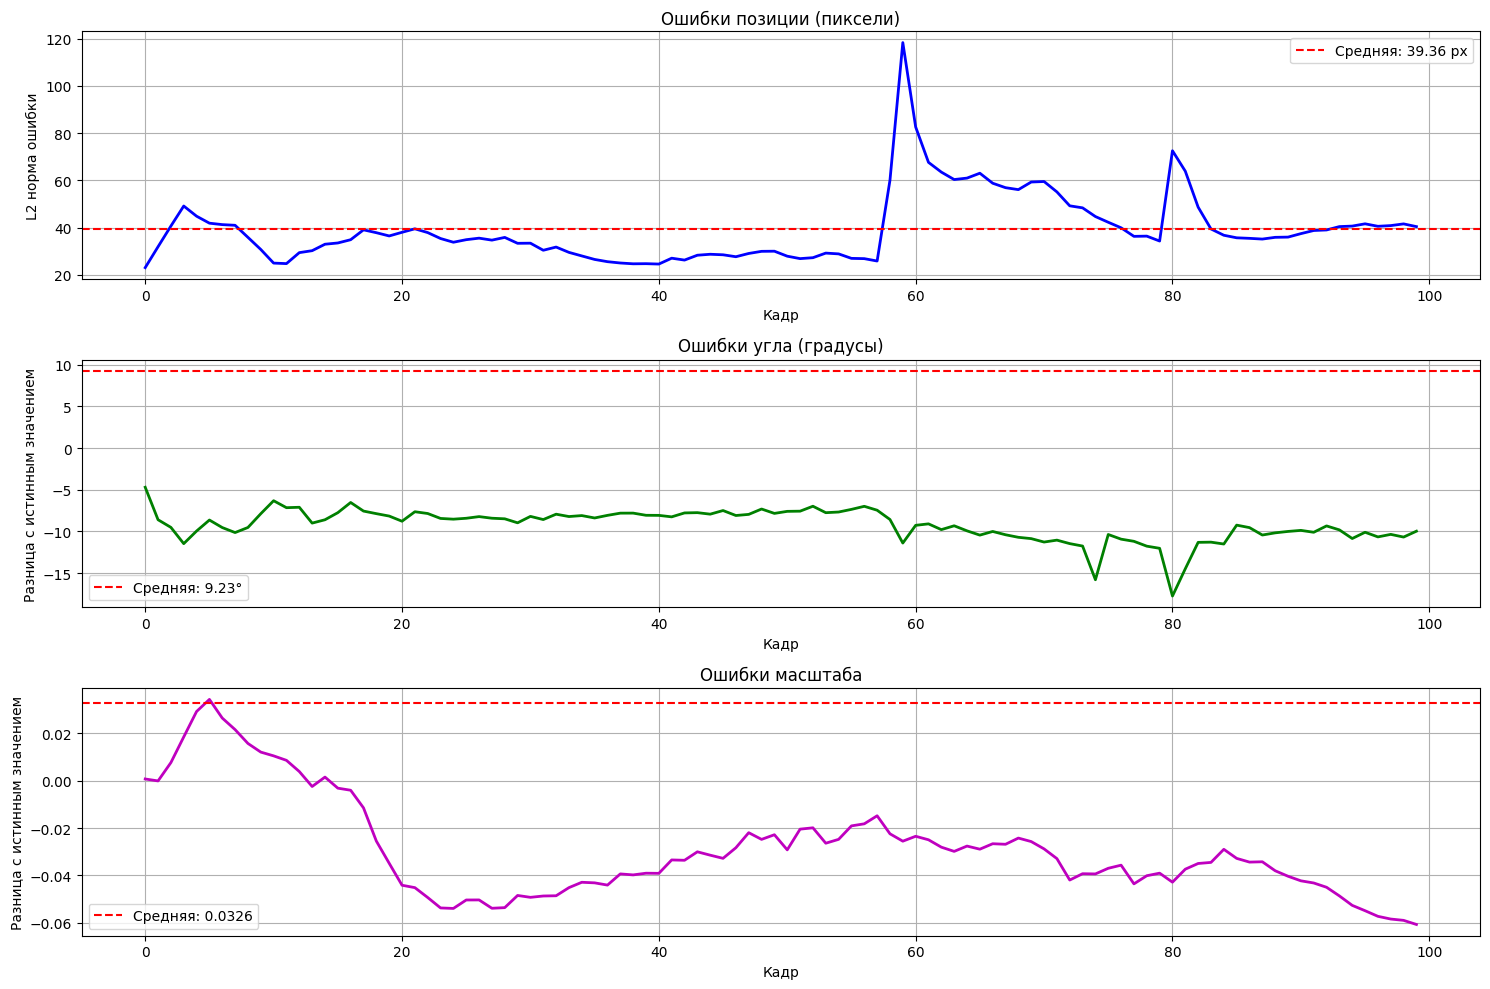


Статистика ошибок:
Позиция: средняя = 39.36 px, max = 118.28 px
Угол: средняя = 9.23°, max = 17.75°
Масштаб: средняя = 0.0326, max = 0.0607


In [ ]:
#visualize results
plt.figure(figsize=(15, 10))
    
    # График ошибок позиции
plt.subplot(3, 1, 1)
plt.plot(pos_err, 'b-', linewidth=2)
plt.title('Ошибки позиции (пиксели)')
plt.xlabel('Кадр')
plt.ylabel('L2 норма ошибки')
plt.grid(True)

# Добавляем среднюю ошибку
avg_pos_err = np.mean(pos_err)
plt.axhline(y=avg_pos_err, color='r', linestyle='--', 
            label=f'Средняя: {avg_pos_err:.2f} px')
plt.legend()

# График ошибок угла
plt.subplot(3, 1, 2)
plt.plot(angle_err, 'g-', linewidth=2)
plt.title('Ошибки угла (градусы)')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_angle_err = np.mean(np.abs(angle_err))
plt.axhline(y=avg_angle_err, color='r', linestyle='--',
            label=f'Средняя: {avg_angle_err:.2f}°')
plt.legend()

# График ошибок масштаба
plt.subplot(3, 1, 3)
plt.plot(scale_err, 'm-', linewidth=2)
plt.title('Ошибки масштаба')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_scale_err = np.mean(np.abs(scale_err))
plt.axhline(y=avg_scale_err, color='r', linestyle='--',
            label=f'Средняя: {avg_scale_err:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод статистики
print("\nСтатистика ошибок:")
print(f"Позиция: средняя = {avg_pos_err:.2f} px, max = {np.max(pos_err):.2f} px")
print(f"Угол: средняя = {avg_angle_err:.2f}°, max = {np.max(np.abs(angle_err)):.2f}°")
print(f"Масштаб: средняя = {avg_scale_err:.4f}, max = {np.max(np.abs(scale_err)):.4f}")

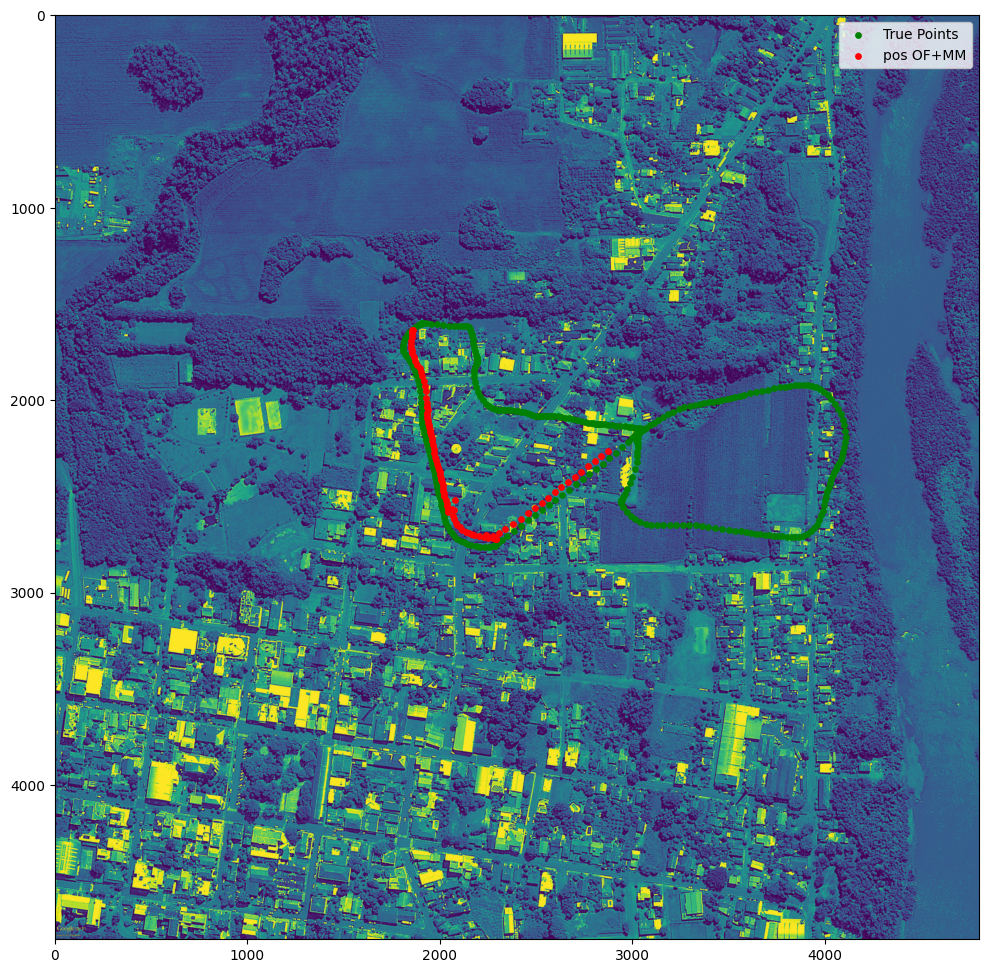

In [ ]:
#visualize results on map
position = np.array(position)

plt.figure(figsize=(12, 12))
plt.imshow(K.tensor_to_image(TMAP))

# TRUE_PS (N, 2) — уже правильно
plt.scatter(TRUE_PS[:, 0], TRUE_PS[:, 1], s=15, c='green', label='True Points')

# pos_MM (N, 2) — рисуем все точки
plt.scatter(position[:,0], position[:,1], s=15, c='red', label='pos OF+MM')

# pos_PM (N, 2) — рисуем все точки
#plt.scatter(pos_PM[:,0], pos_PM[:,1], s=40, c='green', marker='o', label='PM Positions')

plt.legend()
plt.show()

In [52]:
pos0, angle0, scale0 = get_ground_truth_adm(0)

position = []
angles = []
scales = []
pos_MM = []
pos_PM = []
pos_err = []
angle_err = []
scale_err = []
of = []

Kk = 1.5


#getting initial coordinates
pos_now = pos0
angle_now = angle0
scale_now = scale0

position.append(pos_now)
angles.append(angle_now)
scales.append(scale_now)
pos_MM.append(pos_now)
pos_PM.append(pos_now)

#start fly
img_past = get_tframe_LoFTR(0)
for idx in tqdm(range(1, FRAMES_NUM)):
    
    img = get_tframe_LoFTR(idx)

    true_pos, true_angle, true_scale = get_ground_truth_adm(idx)

    #pair matching with past image
    dp_PM, pos_pred_PM, da_PM, ds_PM, inliers_PM, outliers_PM = pair_match_predict_LoFTR(img_past, img, pos_now, angle_now, true_scale)

    #map matching
    aed_MM, dp_MM, pos_pred_MM, da_MM, ds_MM, inliers_MM, outliers_MM = map_match_LoFTR(TMAP, img, pos_now+dp_PM, angle_now+da_PM, true_scale, Kk)

    pos_MM.append(pos_pred_MM)
    pos_PM.append(pos_pred_PM)

    #combination of methods results
    if (outliers_MM<30):
        of.append(idx)
        pos_now = pos_now+dp_PM
        angle_now = angle_now + da_PM
        scale_now = scale_now
    else:
        pos_now = pos_pred_MM
        angle_now = angle_now + da_PM
        scale_now = scale_now + ds_MM
    
    position.append(pos_now)
    angles.append(angle_now)
    scales.append(scale_now)
    img_past = img # Явное копирование без градиентов
    #print(f'TRUE POS: {true_pos}; predict POS: {pos_now}; POS error: {np.linalg.norm(true_pos - pos_now)}')
    pos_err.append(np.linalg.norm(pos_now-true_pos))
    angle_err.append((lambda x : x if x < 180 else np.abs(x - 360))(np.abs(angle_now - true_angle)))
    scale_err.append(true_scale - scale_now)
    torch.cuda.empty_cache()
print(of)

100%|██████████| 357/357 [12:06<00:00,  2.03s/it]

[23, 24, 25, 26, 227, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 261, 262, 263, 306, 307, 311, 312, 313, 314, 315, 316, 317, 318, 320, 321, 322, 326, 354]


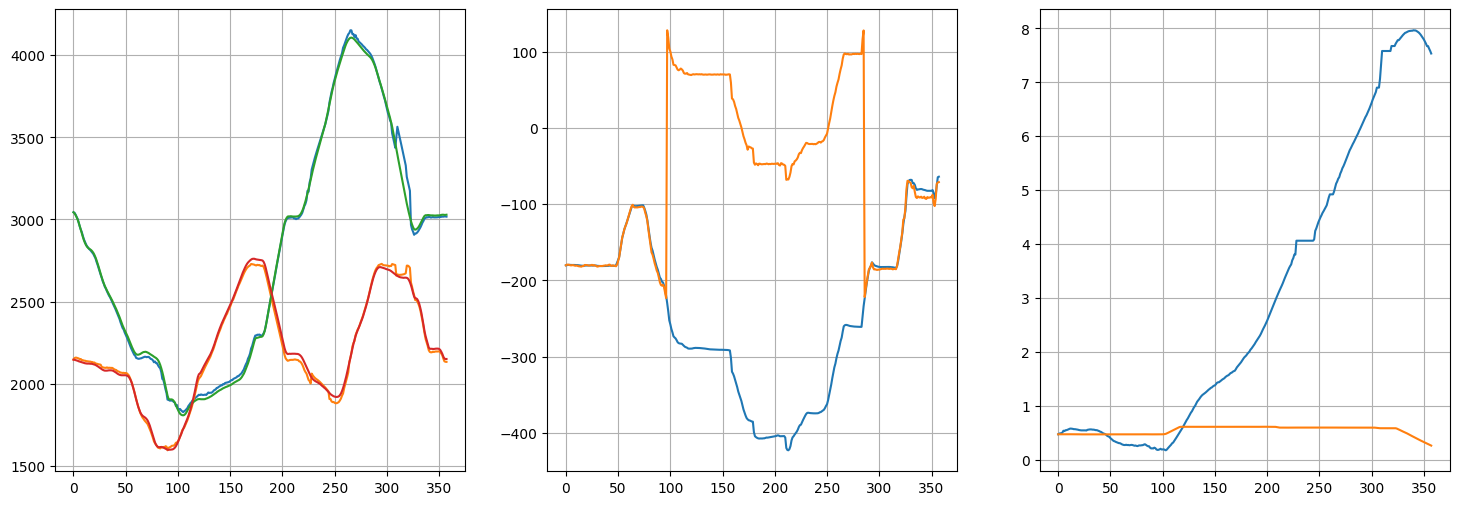

39


In [56]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(position)
plt.plot(TRUE_PS)
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(angles)
plt.plot(TRUE_AS)
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(scales)
plt.plot(TRUE_SS)
plt.grid()

plt.show()
print(len(of))


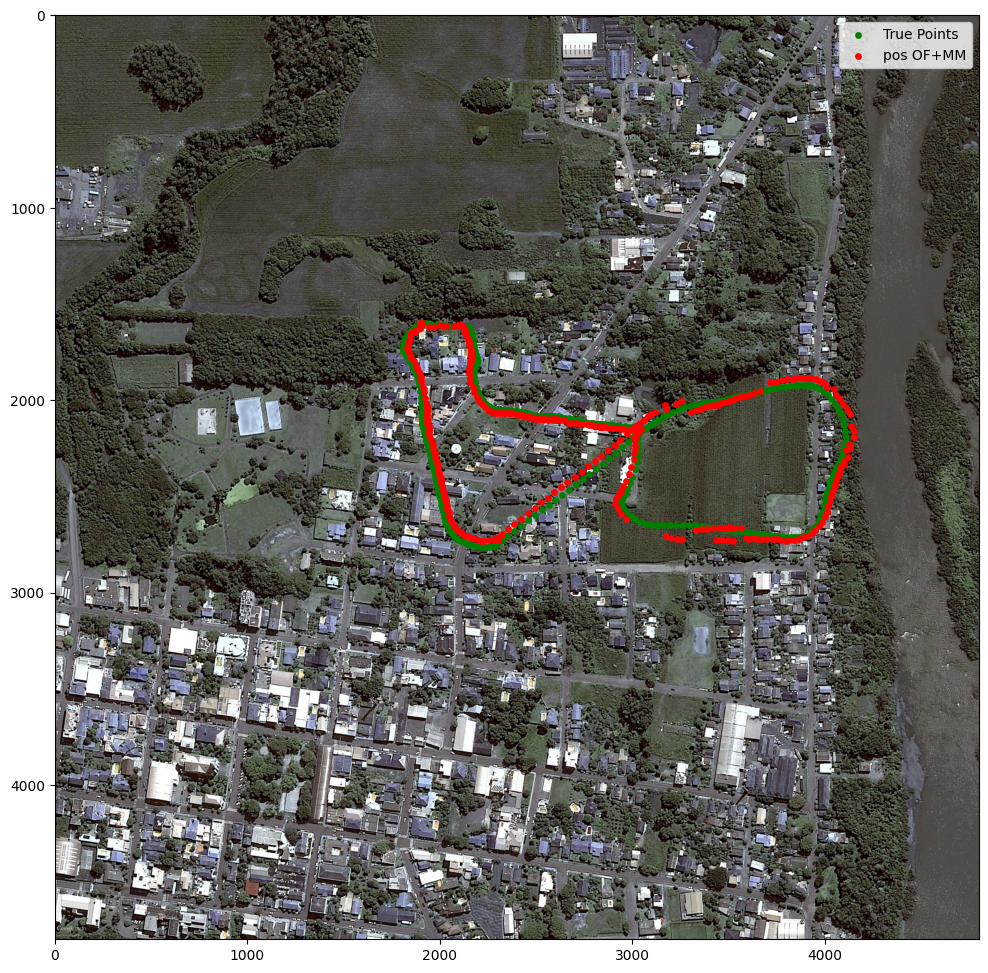

In [57]:
#visualize results on map
position = np.array(position)

plt.figure(figsize=(12, 12))
plt.imshow(cv2.imread(f'Maps/{MAP_NAME}.png', cv2.IMREAD_COLOR))

# TRUE_PS (N, 2) — уже правильно
plt.scatter(TRUE_PS[:, 0], TRUE_PS[:, 1], s=15, c='green', label='True Points')

# pos_MM (N, 2) — рисуем все точки
plt.scatter(position[:, 0], position[:, 1], s=15, c='red', label='pos OF+MM')

# pos_PM (N, 2) — рисуем все точки
#plt.scatter(pos_PM[:,0], pos_PM[:,1], s=40, c='green', marker='o', label='PM Positions')

plt.legend()
plt.show()

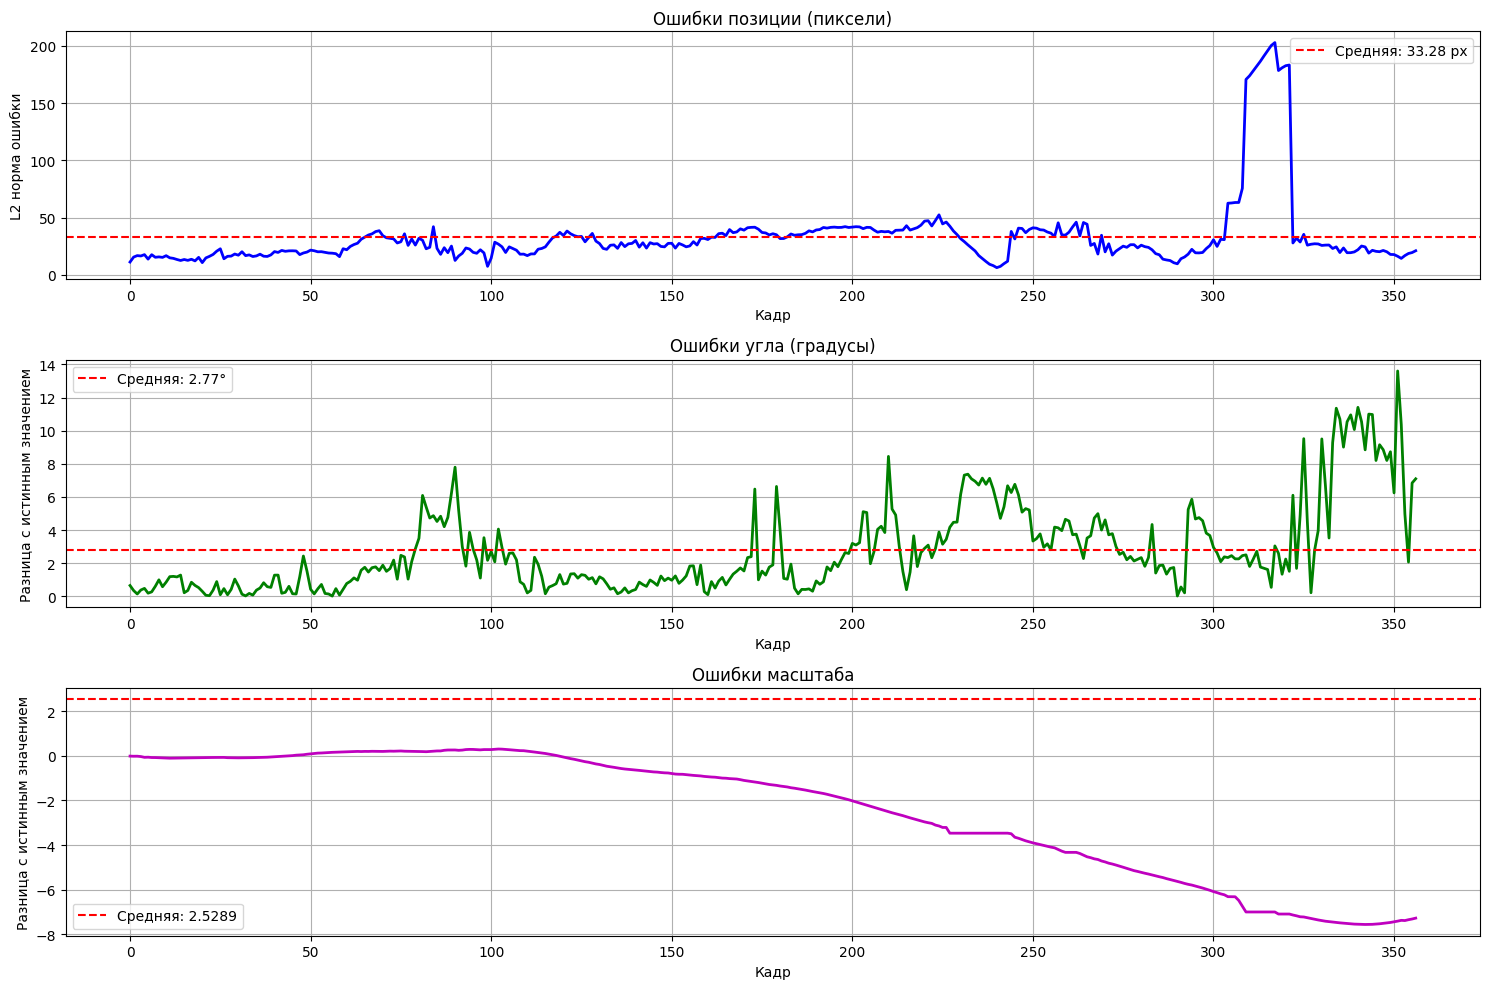


Статистика ошибок:
Позиция: средняя = 33.28 px, max = 202.72 px, в метрах: 8.041758049102592
Угол: средняя = 2.77°, max = 13.60° min значение: -223.255, max значение: 127.882, % ошибки: 0.790175453836652
Масштаб: средняя = 2.5289, max = 7.5579, min значение: 0.2613310156, max значение: 0.6108457813, % ошибки: 723.5361292700328
Конечная позиция: (array([3017.35410325, 2133.43293643]),), истинная: [3029. 2151.], ошибка: 21.076732047592778 px, 5.093543578168255 m


In [61]:
#visualize results
plt.figure(figsize=(15, 10))
    
    # График ошибок позиции
plt.subplot(3, 1, 1)
plt.plot(pos_err, 'b-', linewidth=2)
plt.title('Ошибки позиции (пиксели)')
plt.xlabel('Кадр')
plt.ylabel('L2 норма ошибки')
plt.grid(True)

# Добавляем среднюю ошибку
avg_pos_err = np.mean(pos_err)
plt.axhline(y=avg_pos_err, color='r', linestyle='--', 
            label=f'Средняя: {avg_pos_err:.2f} px')
plt.legend()

# График ошибок угла
plt.subplot(3, 1, 2)
plt.plot(angle_err, 'g-', linewidth=2)
plt.title('Ошибки угла (градусы)')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_angle_err = np.mean(np.abs(angle_err))
plt.axhline(y=avg_angle_err, color='r', linestyle='--',
            label=f'Средняя: {avg_angle_err:.2f}°')
plt.legend()

# График ошибок масштаба
plt.subplot(3, 1, 3)
plt.plot(scale_err, 'm-', linewidth=2)
plt.title('Ошибки масштаба')
plt.xlabel('Кадр')
plt.ylabel('Разница с истинным значением')
plt.grid(True)

avg_scale_err = np.mean(np.abs(scale_err))
plt.axhline(y=avg_scale_err, color='r', linestyle='--',
            label=f'Средняя: {avg_scale_err:.4f}')
plt.legend()

plt.tight_layout()
plt.show()

# Вывод статистики
print("\nСтатистика ошибок:")
print(f"Позиция: средняя = {avg_pos_err:.2f} px, max = {np.max(pos_err):.2f} px, в метрах: {avg_pos_err*MAP_GSD}")
print(f"Угол: средняя = {avg_angle_err:.2f}°, max = {np.max(np.abs(angle_err)):.2f}° min значение: {TRUE_AS.min()}, max значение: {TRUE_AS.max()}, % ошибки: {avg_angle_err/(TRUE_AS.max() - TRUE_AS.min())*100}")
print(f"Масштаб: средняя = {avg_scale_err:.4f}, max = {np.max(np.abs(scale_err)):.4f}, min значение: {TRUE_SS.min()}, max значение: {TRUE_SS.max()}, % ошибки: {avg_scale_err/(TRUE_SS.max() - TRUE_SS.min())*100}")
print(f'Конечная позиция: {position[-1], }, истинная: {TRUE_PS[-1]}, ошибка: {pos_err[-1]} px, {pos_err[-1]*MAP_GSD} m')